# Network Science model in Jupiter Notebook with Netwokx

## Imports and class definitions

In [1]:
# Imports
import os,glob
import numpy as np
import networkx as nx
import pandas as pd
import random, string, time
import pylab
import collections
from natsort import natsorted
from matplotlib import pyplot as plt
import imageio
%matplotlib inline
from IPython import display
from IPython.display import clear_output
import io,pickle
# import urllib, base64
try:
    import randomnames
    rndnames_imported = True
except:
    rndnames_imported = False

#Classes and methods

def randInt(maxn=100, minn=0):
    return minn + np.random.randint(maxn-minn, size=1)[0]

def randStr(stringLength=10, kind=None):
    if kind is None or rndnames_imported is False:
        letters = string.ascii_lowercase
        return ''.join(random.choice(letters) for i in range(stringLength))
    elif kind.lower()=='name':
        return random.choice(randomnames.NAMES).title() + ' '+random.choice(randomnames.SURNAMES).title()
    else: #if kind.lower()=='book':
        return random.choice(randomnames.ADJECTIVES).title() + ' '+random.choice(randomnames.NOUNS).title()        

def getLogicChoice(options):
    array = [x for x in options for y in range(options[x])]
    random.shuffle(array)
    if bool(array):
        return random.choice(array)
    else:
        return None
def decision(probability):
    return random.random() < probability
    
def random_dates(start, end, n=10):
    start_u = start.value//10**9
    end_u = end.value//10**9
    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')
# random_dates(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2019-06-14'))


def save_plot(name):
    if not os.path.exists('plots'):
        os.mkdir('plots')    
    plt.savefig('plots/{}.png'.format(name))
    
def clear_folder(path='plots/*'):
    files = glob.glob(path)
    for file in files:
        os.remove(file)
        
def folder2gif(path='plots/*', filename='simulation.gif'):        

    images = []
    files = natsorted(glob.glob(path))
    for i,file in enumerate(files):
        images.append(imageio.imread(file))
        print("{}/{} frames drawn".format(i+1,len(files)), end='\r')
    if len(images)>0:
        imageio.mimsave(filename, images)   
        
class NETWORK:
    def __init__(self, **params):
        self.G = nx.MultiDiGraph() if (params['create_using'] is None) else params['create_using']
        self.params = params
        self.nodePositions = nx.circular_layout(self.G)
        self.nodeShapes = 'o' 
        if self.params['n_books']<self.params['n_plot_treshold']:
            self.color_map = []
            self.node_sizes = []
            self.transparency = []
        self.opinions = []        
        self.Growth = {}
        self.Growth_users = {}
        self.Reads = self.READS()
        self.Agents = self.USERSHIP()        
        self.Library = self.LIBRARY()
    def decision(self, probability):
        return random.random() < probability
        
    def add_node(self, nid=None, name=randStr(kind='book'), cost=randInt()):
        if nid==None:
            nid=len(self.Library.books)
        self.G.add_node(nid) 
        if self.params['n_books']<self.params['n_plot_treshold']:
            self.color_map.append('gray')
            self.node_sizes.append(0)
            
        self.opinions.append([])
        self.Library.addBook(bid=nid, name=name, cost=cost)
        
        
    def add_edge(self, id1, id2):
        self.G.add_edge(id1, id2)         
    def avgPositions(self, pos0, pos1):
        return {i:( np.mean(np.array([a,b]).transpose(), axis=1) if self.G.degree[i] >0 else a ) for i,(a,b) in enumerate(zip(pos0.values(), pos1.values()))}
        
    def display(self, title=''):    
        
        plt.figure(figsize=(16, 9))
        nx.draw_networkx(self.G, 
                         self.nodePositions, 
                         node_color = self.color_map, 
                         node_size = self.node_sizes,
                         with_labels = True )
        plt.title(title)
        plt.show() 
        
    class READS:
        def __init__(self):
            self.header = ['Timestamp','BookId', 'UserID', 'Cost', 'Feedback']
            self.reads = []  
        def addRead(self, t, bid, uid, cost, feedback):  
            self.reads.append((t, bid, uid, cost, feedback))
        def getDataFrame(self):
            return pd.DataFrame(data=self.reads, columns=self.header) 
        
    class LIBRARY:
        def __init__(self):
            self.header = ['BookId', 'BookName', 'Cost']
            self.books = []           
        def getDataFrame(self):
            return pd.DataFrame(data=self.books, columns=self.header)        
        def addBook(self, bid=None, name=None, cost=0):  
            if bid is None:
                bid=len(self.books)
            self.books.append([bid, name, cost])        
        class Book:
            def __init__(self, bid, name, cost):
                self.id = bid
                self.name = name
                self.cost = cost

    class USERSHIP:
        def __init__(self):
            self.header=['UserId', 'UserName'] 
            self.users = []                   
        def add_user(self, uid=None, name=None):
            if uid is None:
                uid = len(self.users)
            self.users.append(self.User(uid, name))        
        def get_size(self):
            return len(self.users)
        def get_n_active(self):
            return len([user for user in self.users if user.active and user.initialized])
        def getDataFrame(self):
            users = [[user.id, user.name] for user in self.users]
            return pd.DataFrame(data=users, columns=self.header)
        def save_CSV(self, filename='results/Users.CSV'):
            folder = os.path.split(filename)[:-1][0]            
            if not os.path.exists(folder):
                os.makedirs(folder)        
            self.getDataFrame().to_csv( filename , index=False ) 
        class User:
            def __init__(self, uid, name=randStr(8)):
                self.id = uid
                self.name = name
                self.reads = []
                self.active = True
                self.initialized = False 
            def __get__(self):
                return {'uid':self.id, 'name':self.name, 'reads':self.reads}
            def read(self, bid):
        #         self.reads.update({len(self.reads):bid})
                self.reads.append(bid)
            def get_opinion(self, a=1, b=-1, p=0.52):
                return a if random.uniform(0,1) < p else b   

## Simulation

### Parameters

In [2]:
# Parameters
params = {
    'n_books' : 200, # Number of Nodes in the Graph
    'n_agents' : 50, # Number of Agents (Actions per epoch, each agent trails its own path)
    'n_agents_init': 0, # Number of Agents at the simulation begining
    'create_using' : nx.MultiDiGraph(),
    'seed' : None, # Integer seed number or None
    'epochs': 40, # Number of epochs
    'n_plot_treshold' : 250, # A treshold for number of nodes. If there are more nodes than this, then simplified visualiztion will be used
    'updatable_plot': True, # display with updating plot by each epoch OR display whole epochs set to None to disable any plots
    'show_agents': True
}

# Probabilities for an event happening at each event
# The values must be integers. There is onle one of those will be triggered by a single agent per epoch

# There is a single event1 each epoch for every active agent
event1 = {
    'alpha': 20, # P for adding a new node connected to an existing node chosen randomly 
                    # according to the in-degree distribution
    'beta': 20, # P for adding an edge between two exisiting nodes. 
                    # One existing node is chosen randomly - according to the in-degree distribution 
                    # and the other chosen randomly according to the out-degree distribution.
    'gamma': 20, # P for adding a new node connected to an exsisting node chosen randomly 
                    #according to the out-degree distribution
    'delta_in': 20, # Bias for choosing nodes from in-degree distribution.
    'delta_out':20 # Bias for choosing nodes from out-degree distribution.
} 

# event2 hapens right after event1. every type happens once per epoch except 'eta'
event2 = {
    'epsilon': 1, # P for no event
    'zeta': 15,# P for a new agent at a random node
    'eta': 25, # P for an agent inviting a new agent (should also be influenced by a node's feedback)
    'theta': 0, # P for adding a new book
    'iota': 0, # P for activating a non-active user
    'kappa': 15 # P for deactivating an active user
}

### Generating CSV files with random books and users

In [3]:
def generateBookCSV(n=1, filename='results/Books.CSV'):
    header = ['BookId', 'BookName', 'Cost']
    books = [] 
    for i in range(n):
        books.append([i, randStr(kind='book'), randInt(maxn=100, minn=1)])    
    df_books = pd.DataFrame(data=books, columns=header)
    
    folder = os.path.split(filename)[:-1][0]            
    if not os.path.exists(folder):
        os.makedirs(folder)        
    df_books.to_csv( filename , index=False ) 
    return df_books

file_books = 'results/Books.CSV'
generateBookCSV(n=params['n_books'], filename=file_books)

,BookId,BookName,Cost
0,0,Itchy Chicken,96
1,1,Ratty Door,6
2,2,Harebrained Kitty,67
3,3,Nonsensical Leg,74
4,4,Uptight Birthday,37
5,5,Agitated Watch,66
6,6,Greasy School,68
7,7,Curved Shoe,8
8,8,Straight Sun,60
9,9,Intrigued Boy,42


In [4]:
def generateUserCSV(n=1, filename='results/Users.CSV'):
    header = ['UserId', 'UserName'] 
    users = [] 
    for i in range(n):
        users.append([i, randStr(kind='name')])    
    df_users = pd.DataFrame(data=users, columns=header)
    
    folder = os.path.split(filename)[:-1][0]            
    if not os.path.exists(folder):
        os.makedirs(folder)        
    df_users.to_csv( filename , index=False ) 
    return df_users

file_users ='results/Users.CSV'
generateUserCSV(n=params['n_agents'], filename=file_users)

,UserId,UserName
0,0,Leonard Ehrmann
1,1,Wendell Tarantino
2,2,Erik Correa
3,3,Yasmin Calle
4,4,Ralph Ruch
5,5,Vivienne Ruch
6,6,Taisha Nishimura
7,7,Von Riggin
8,8,Wally Korth
9,9,Bryon Herrera


### Graph initialization

In [5]:
# Initial graph
random.seed(params['seed'])
np.random.seed(params['seed'])

Network = NETWORK(**params)

# Load users from CSV
# for i in range(params['n_agents']):
for i,row in enumerate(pd.read_csv("results/Users.CSV").iterrows()):
    Network.Agents.add_user(uid=row[1][0], name=row[1][1])
    
# Initialize very first users
for ruid in random.sample(range(params['n_agents']), k=params['n_agents_init']):
    Network.Agents.users[ruid].initialized = True    
    

for i,row in enumerate(pd.read_csv("results/Books.CSV").iterrows()):          
    Network.add_node(nid=row[1][0], name=row[1][1], cost=row[1][2])  
    if params['n_books']<params['n_plot_treshold'] or (i+1)%int(np.ceil(params['n_books']/100))==0:
        print("{}/{} nodes created".format(i+1,params['n_books']), end='\r')   

if params['n_books']<params['n_plot_treshold']:
    Network.nodePositions = nx.spring_layout(Network.G, iterations=1) 
else:
    Network.nodePositions = nx.random_layout(Network.G) 

### Simulation

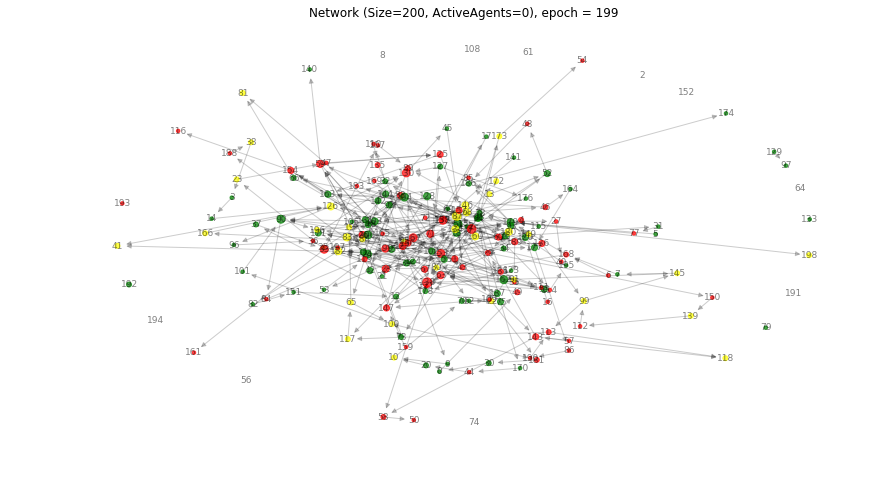

In [6]:
# Plot methods

if params['updatable_plot']:
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.axis('off')  
elif params['updatable_plot']==False:
    columns, rows = 2, (1+params['epochs'])/2    
    fig = plt.figure(figsize=(15, 15*rows/2))
    plt.axis('off')    
def plotGraph(i=0, ax=None, lastreads=[]): # method for plotting nodes, edges, labels and clearing the plot each iteration     
    if params['updatable_plot']:
        ax.set_title("Network (Size={}, ActiveAgents={}), epoch = {}".format(len(Network.Library.books), Network.Agents.get_n_active(), i))
        plt.axis('off')
    elif params['updatable_plot']==False:
        plt.title("Network (Size={}, ActiveAgents={}), epoch = {}".format(len(Network.Library.books), Network.Agents.get_n_active(), i))
        plt.axis('off')
        
    if params['n_books']<params['n_plot_treshold']:
        gnodes = nx.draw_networkx_nodes(Network.G, 
                        pos=Network.nodePositions, 
                        node_color = Network.color_map, 
                        node_size = [i*(100*25/params['n_books']) for i in Network.node_sizes],
                        node_shape = Network.nodeShapes,
                        alpha = 0.7,
                        with_labels = True,
                        ax=ax)
        if len(lastreads)>0 and params['show_agents']:
            gnodes_a = nx.draw_networkx_nodes(Network.G, 
                                              pos=Network.nodePositions,
                                              node_size=200, node_color='m', 
                                              nodelist=lastreads, node_shape='v')
        gedges = nx.draw_networkx_edges(Network.G, 
                        pos=Network.nodePositions,
                        alpha = 0.2,
                        with_labels = True,
                        ax=ax)    
        glabels = nx.draw_networkx_labels(Network.G,
                        pos={nd:Network.nodePositions[nd]+[0,0.00] for nd in Network.nodePositions},
                        alpha = 0.5,
                        font_size = 9,
                        labels = {b[0]:b[0] for b in Network.Library.books},
                        ax=ax)     
    else:
        gnodes = nx.draw_networkx_nodes(Network.G, 
                        pos=Network.nodePositions, 
                        node_size = 1, 
                        node_color = 'black',                
                        alpha = 0.6,
                        ax=ax)
        gedges = nx.draw_networkx_edges(Network.G, 
                        pos=Network.nodePositions,
                        edge_color = 'red', 
                        alpha = 0.5,
                        ax=ax)

clear_folder()


# Simulation loop

epochTimes = []

for i,epoch in enumerate(range(params['epochs'])):  
    now = time.time()
    lastreads = []  
    for ui,user in enumerate(Network.Agents.users):
        if user.active and user.initialized:
            # decision on which node to distribute
            choice1 = getLogicChoice(event1)
            if choice1 == 'alpha':
                read = getLogicChoice(options={node:degree+1 for node,degree in Network.G.in_degree if degree==0})
            elif choice1 == 'beta':
                read = getLogicChoice(options={node:degree+1 for node,degree in Network.G.in_degree if degree>0})
            elif choice1 == 'gamma':
                read = getLogicChoice(options={node:degree+1 for node,degree in Network.G.out_degree if degree==0})
            elif choice1 == 'delta_in':
                read = getLogicChoice(options={node:degree+1 for node,degree in Network.G.in_degree})
            elif choice1 == 'delta_out':
                read = getLogicChoice(options={node:degree+1 for node,degree in Network.G.out_degree})
            else:
                read = None
    #       
            if read != None and read not in Network.Agents.users[ui].reads:  
                lastreads.append(read)
                if len(Network.Agents.users[ui].reads) > 0:
                    Network.add_edge(user.reads[-1], read)

                user.reads.append(read)  
                feedback = user.get_opinion()
                Network.opinions[read].append(feedback)
                if params['n_books']<params['n_plot_treshold']:
                    whole_fb = sum(Network.opinions[read])  
                    Network.color_map[read] = 'yellow' if abs(whole_fb)<0.2 else ('green' if whole_fb>0 else 'red') 
                    Network.node_sizes[read] +=1
                Network.Reads.addRead(i, read, ui, Network.Library.books[read][2], feedback)
                Network.Growth[i] = [v for (k,v) in Network.G.degree if v>0]

            if Network.params['n_books']<Network.params['n_plot_treshold']:
                Network.nodePositions = nx.spring_layout(Network.G, pos=Network.nodePositions, iterations=1) 
                
            if Network.Agents.users[ui].reads == params['n_books']:
                Network.Agents.users[ui].active = False
    
                
    choice2 = getLogicChoice(event2)
    if choice2 == 'epsilon':
        invite = None
    elif choice2 == 'zeta':
        invite = getLogicChoice(options={node:1 for node,degree in Network.G.degree})
        Network.Agents.add_user(name=randStr(kind='name'))
        uid = random.sample(range(params['n_agents']), k=1)[0]
        Network.Agents.users[uid].initialized = True
    elif choice2 == 'eta':
        uid = random.sample(range(params['n_agents']), k=1)[0]
        Network.Agents.users[uid].initialized = True
        avgedopinions=[(np.mean(fb) if len(fb)>0 else 0.0) for fb in Network.opinions]        
        invite = getLogicChoice(options={node:score for node,score in enumerate([int(np.sqrt(10*(op+1)/2)) for op in avgedopinions])})

        Network.Agents.users[uid].reads.append(invite) 
        feedback = Network.Agents.users[uid].get_opinion()
        Network.opinions[invite].append(feedback)
        if params['n_books']<params['n_plot_treshold']:
            whole_fb = sum(Network.opinions[invite])  
            Network.color_map[invite] = 'yellow' if abs(whole_fb)<0.2 else ('green' if whole_fb>0 else 'red') 
            Network.node_sizes[invite] +=1
        Network.Reads.addRead(i, invite, ui, Network.Library.books[invite][2], feedback)

        lastreads.append(invite)
    elif choice2 == 'theta':
        invite = None
        bid=len(Network.Library.books)
        Network.add_node(nid=bid, name=randStr(kind='book'), cost=randInt())
        Network.nodePositions.update({len(Network.nodePositions):(np.random.rand(2)*2-1)+0.5})

    elif choice2 == 'iota':
        invite = getLogicChoice(options={userid:1 for userid in [user.id for user in Network.Agents.users if (not user.active and user.initialized)]})
        if not invite is None:
            Network.Agents.users[invite].active = True
    elif choice2 == 'kappa':
        invite = getLogicChoice(options={userid:1 for userid in [user.id for user in Network.Agents.users if (user.active and user.initialized)]})
        if not invite is None:
            Network.Agents.users[invite].active = False
    else:
        invite = None
        
    Network.Growth_users[i] = Network.Agents.get_n_active()   
    Network.Growth[i] = [v for (k,v) in Network.G.degree if v>0]
    then = time.time()
    # Plotting nodes, edges, labels
    def plotting(spi_adj=0):
        if params['updatable_plot']:
            display.clear_output(wait=True) 
            plotGraph(i=i,ax=ax,lastreads=lastreads)
            display.display(pylab.gcf())
            save_plot(str(i)+'_'+str(spi_adj))
            plt.cla()
            if i == params['epochs']-1:
                plt.close()  
        elif params['updatable_plot']==False:
            fig.add_subplot(rows, columns, i+1)
            plotGraph(i=i,lastreads=lastreads)
            save_plot(str(i)+'_'+str(spi_adj))
            if i == params['epochs']-1:
                plt.show()
        else:
            print("{}/{} epochs done".format(i+1,params['epochs']), end='\r')        
    plotting() 
#     Network.nodePositions = nx.spring_layout(Network.G, pos=Network.nodePositions, iterations=2)
#     plotting(1) 
#     Network.nodePositions = nx.spring_layout(Network.G, pos=Network.nodePositions, iterations=2)
#     plotting(2) 
            
    epochTimes.append(then - now)     

In [122]:
# Create a gif from the simulation

if params['updatable_plot'] is not None: 
    if not os.path.exists('results'):
        os.mkdir('results')
    folder2gif(filename = os.path.join('results','simulation.gif'))

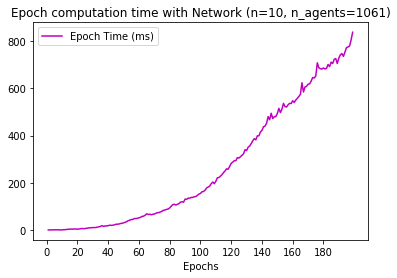

In [128]:
# Simulation speed plot
# Epoch time graph represents the time for each epoch of the simulation, this is to see how long it takes for each epoch to be simulated.

plt.xlabel('Epochs')
plt.plot(np.array(range(len(epochTimes)))[1:], np.array(epochTimes)[1:]/0.001, 'm-', label='Epoch Time (ms)')
pylab.legend(loc='upper left')
plt.title("Epoch computation time with Network (n={}, n_agents={})".format(len(Network.Library.books), len(Network.Agents.users)))
plt.xticks([i for i in range(params['epochs']) if i%(params['epochs']/10)==0])
plt.show()

### Pandas dataframe

In [129]:
reads_dataframe = Network.Reads.getDataFrame().sort_values(by=['Timestamp'])

# Assume random datetimes
# create random names within specified time period
def random_dates(start, end, n=10):
    start_u = start.value//10**9
    end_u = end.value//10**9
    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

rnddates = sorted(random_dates(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2019-06-14'), n=len(reads_dataframe['Timestamp'].unique()) ))
mapping_epoch2dates = {k:v for k,v in zip(reads_dataframe['Timestamp'].unique(),rnddates)}

# reads_dataframe
# reads_dataframe['Datetime'] = sorted(random_dates(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2019-06-14'), n=len(reads_dataframe) ))
# reads_dataframe.sort_values(by=['Timestamp'])


def applyEpochDateMapping(row):    
    return mapping_epoch2dates[row['Timestamp']]

reads_dataframe['Datetime'] = reads_dataframe.apply(lambda row: applyEpochDateMapping(row), axis=1)
reads_dataframe

,Timestamp,BookId,UserID,Cost,Feedback,Datetime
0,1,9,108,72,1,2015-01-06 13:47:40
1,2,8,108,11,1,2015-01-19 13:49:37
2,2,3,354,36,-1,2015-01-19 13:49:37
3,2,9,1001,72,-1,2015-01-19 13:49:37
4,3,4,108,58,1,2015-01-27 11:26:00
5,3,0,354,23,-1,2015-01-27 11:26:00
6,3,8,924,11,1,2015-01-27 11:26:00
7,3,6,1001,73,1,2015-01-27 11:26:00
10,4,4,924,58,-1,2015-02-02 20:19:56
8,4,4,354,58,1,2015-02-02 20:19:56


#### Write generated data to CSV file

In [86]:
if not os.path.exists('results'):
    os.mkdir('results')
      
reads_dataframe.to_csv( os.path.join('results', 'Reads.CSV') , index=False )    

#### Rebuilding graph edges for exact time period using Reads dataframe

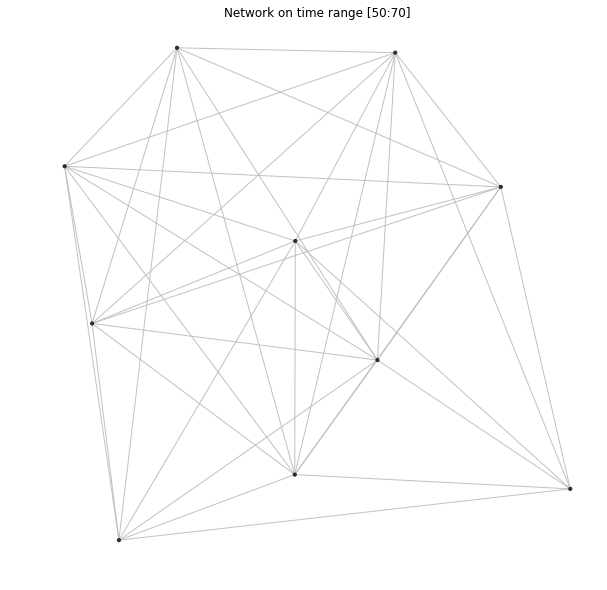

In [130]:
start_stamp = 50
end_stamp = 70

last_reads = {}

G_tmp = nx.Graph()
G_tmp.add_nodes_from(Network.G)

cols = ['#4f4fff' for n in G_tmp.nodes]

for row in reads_dataframe.iterrows():
    if row[1]['Timestamp'] >= start_stamp and row[1]['Timestamp'] <= end_stamp:
        if row[1]['UserID'] in last_reads:
            G_tmp.add_edge(last_reads[row[1]['UserID']], row[1]['BookId']) 
        last_reads.update({row[1]['UserID']: row[1]['BookId']})
        cols[ row[1]['BookId'] ] = '#1f1f1f'
        
# pos = Network.nodePositions         
pos = nx.spring_layout(G_tmp, iterations=50) 


fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Network on time range [{}:{}]".format(start_stamp, end_stamp))
nx.draw(G_tmp, pos=pos , node_size=10, node_color=cols, edge_color='#bbbbbb',  arrows=False, alpha=0.9)

## Analysis plots

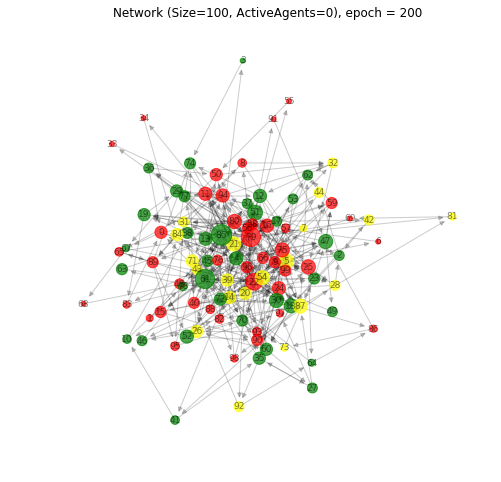

In [117]:
# Final graph

fig, ax = plt.subplots(figsize=(8, 8))
# Network.nodePositions = nx.random_layout(Network.G) 
Network.nodePositions = nx.spring_layout(Network.G, iterations=20)
plotGraph(params['epochs'], ax=ax)
plt.show()

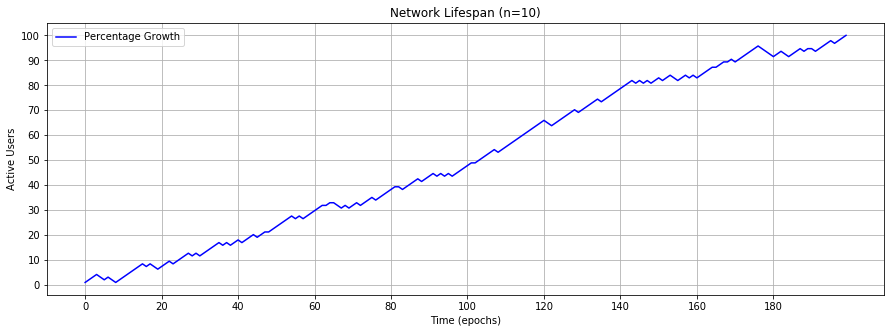

In [131]:
from scipy.optimize import curve_fit

SHOW_PERCENTAGE = True

xData = np.array(list(Network.Growth.keys()))#[1:]
yData = np.array([len(e) for e in Network.Growth.values()])#[1:]
yData_users = np.array([e for e in Network.Growth_users.values()])#[1:]
if SHOW_PERCENTAGE:
    yData_users = [100*x/max(yData_users) for x in yData_users]
# [(x/max(Network.Growth_users.values()))*100 for x in list(set(Network.Growth_users.values()))]
dData = rnddates+rnddates#[np.datetime64(mapping_epoch2dates[e]) for e in Network.Growth.keys()]
# lx = np.nan_to_num(np.log(xData))
# ly = np.nan_to_num(np.log(yData))
# lx[np.isnan(lx)] = 0.1
# ly[np.isnan(ly)] = 0.1
# lx = np.log(xData)
# ly = np.log(yData)
# def f(x, N, a):
#     return N * x ** (-a)
# def f_log(x, lN, a):
#     return a * x + lN
# optimize using the appropriate bounds
# popt, pcov = curve_fit(f, xData, yData, bounds=(0, [30., 20.]))
# popt_log, pcov_log = curve_fit(f_log, lx, ly)#, bounds=([0, -10], [30., 20.]))

# plot the data
fig, ax = plt.subplots(figsize=(15,5))
# plt.title('Network Lifespan')
plt.title("Network Lifespan (n={})".format(len(Network.Library.books)))
plt.xlabel('Time (epochs)')
plt.ylabel('Active Users')

# ax.plot(xData, yData, 'b-', label='Connected Books')
if SHOW_PERCENTAGE:
    ax.plot(xData, yData_users, 'b-', label='Percentage Growth')
else:
    ax.plot(xData, yData_users, 'm-', label='Active Users')
    
# ax.plot(xData, f_log(xData, np.exp(popt_log[0]), -pcov_log[1]), 'k', label='Curve')
# plt.plot(dData, yData, 'b-', label='Actual')


# plt.xticks(xData)
ax.grid(True)
pylab.legend(loc='upper left')

# plt.xticks(xData, dData, rotation='80') 
plt.xticks([i for i in range(params['epochs']) if i%(params['epochs']/10)==0], rotation='0')


if SHOW_PERCENTAGE:
#     plt.yticks([100*x/max(Network.Growth_users.values()) for x in list(set(Network.Growth_users.values()))])
    plt.yticks([i for i in range(101) if i%10==0], rotation='0')
plt.show()

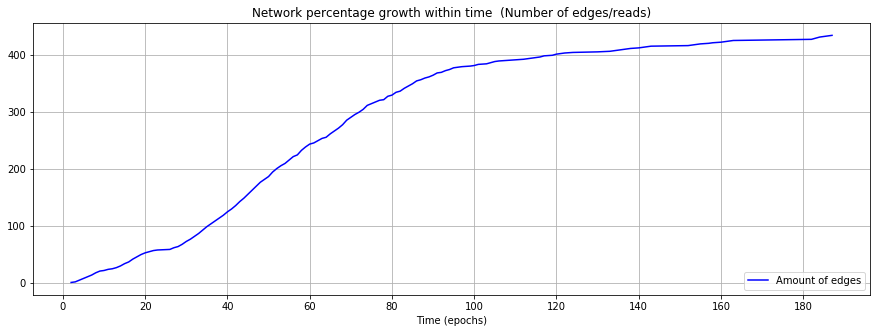

In [120]:
edgesByEpoch = {}
last_reads = {}
totalEdges = 0
for row in reads_dataframe.iterrows():
    if row[1]['UserID'] in last_reads:
        totalEdges+=1
        if row[1]['Timestamp'] in edgesByEpoch:
            edgesByEpoch[row[1]['Timestamp']]+=1            
        else:
            edgesByEpoch[row[1]['Timestamp']]=totalEdges

    last_reads.update({row[1]['UserID']: row[1]['BookId']})

    
yData = np.array([v for (k,v) in edgesByEpoch.items()])
yy = [v for (k,v) in edgesByEpoch.items()]
yData2 = np.array([0.0]+[100*y1/y0 for y0,y1 in zip(yy, yy[1:])])

xData = np.array([k for (k,v) in edgesByEpoch.items()])

fig, ax = plt.subplots(figsize=(15,5))
plt.title('Network percentage growth within time  (Number of edges/reads)')
plt.xlabel('Time (epochs)')
# plt.ylabel('Amount of edges / Percentage growth')

ax.plot(xData, yData, 'b-', label='Amount of edges')
# ax.plot(xData, yData2, 'm-', label='Percentage Growth')
# for i, txt in enumerate(yData2):
#     if i%2 != 0:
#         ax.annotate("%.0f %%" %(txt), (xData[i], yData2[i]), rotation=45, size=8)

ax.grid(True)
pylab.legend(loc='lower right')

# plt.xticks(xData, dData, rotation='80') 
plt.xticks([i for i in range(params['epochs']) if i%(params['epochs']/10)==0])
plt.show()

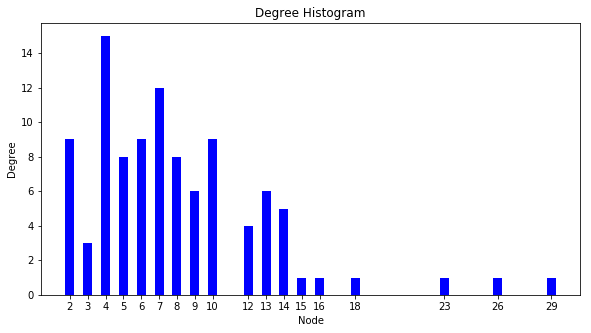

In [121]:
# Plot degree distrbution

degree_sequence = sorted([d for n, d in Network.G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(max(deg)/3,5))

plt.bar(deg, cnt, width=0.50, color='b')
plt.title("Degree Histogram")
plt.ylabel("Degree")
plt.xlabel("Node")

ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)

plt.show()

## Questions
1. Where would I see the number of books per agent, if I were to find out? How would I know how many agents are attracted by which book and volume of books consumed?

In [105]:
# Print book_id read by a particular user
# all reads of a user is stored in .reads variable :

user_id = 0
user_reads =  Network.Agents.users[user_id].reads
print("user {} reads:\n{}".format(user_id,user_reads))


user 0 reads:
[997, 359, 518, 272, 779, 95, 9, 252, 977, 2, 585, 572, 44, 784, 615, 594, 755, 664, 691, 566, 373, 333, 651, 460, 823, 586, 913, 760]


In [106]:
# this is to invert the dict {User: [read books]} to {Book: [read by users]}

booksUsers = {}

for user in Network.Agents.users:
    for book in user.reads:
        if book in booksUsers:
            booksUsers[book].append(user.id)
        else: 
            booksUsers[book] = [user.id]           
booksUsers

{997: [0, 67, 92],
 359: [0, 13, 14, 26, 48, 51, 53, 56, 60, 78],
 518: [0, 4, 13, 21, 29, 29, 40, 42, 49, 51, 83, 84, 89],
 272: [0],
 779: [0, 28, 48, 70, 77, 99],
 95: [0, 1, 10, 11, 14, 28, 40, 56, 66, 72, 74, 74, 81, 84, 87, 91],
 9: [0, 5, 9, 21, 68],
 252: [0, 1, 13, 31, 40, 48, 51, 63, 67, 68, 69, 81, 87, 92, 98],
 977: [0, 33, 58],
 2: [0, 14, 17, 48, 53, 55, 68, 83],
 585: [0, 10, 45],
 572: [0, 14, 36, 48, 72, 81],
 44: [0, 16, 26, 28, 29, 35, 47, 51, 61, 62, 66, 81, 82, 90, 91, 98, 99],
 784: [0],
 615: [0, 68, 97],
 594: [0, 24, 55, 60, 68, 72, 99],
 755: [0, 26, 34, 82, 97, 98, 99],
 664: [0],
 691: [0, 14, 26, 60, 84, 99],
 566: [0, 21, 48, 66, 72],
 373: [0],
 333: [0, 17, 45, 51, 92, 98],
 651: [0, 54, 81],
 460: [0, 1, 18, 28, 40, 99],
 823: [0, 34, 63, 82, 99],
 586: [0, 12, 98],
 913: [0, 40, 63, 82, 95],
 760: [0, 52, 63],
 12: [1, 7, 10, 24, 47],
 360: [1, 10, 14, 55, 78, 81],
 972: [1, 51, 76],
 155: [1, 60, 62, 70, 76],
 261: [1, 3, 14, 28, 34, 35, 40, 44, 74, 7

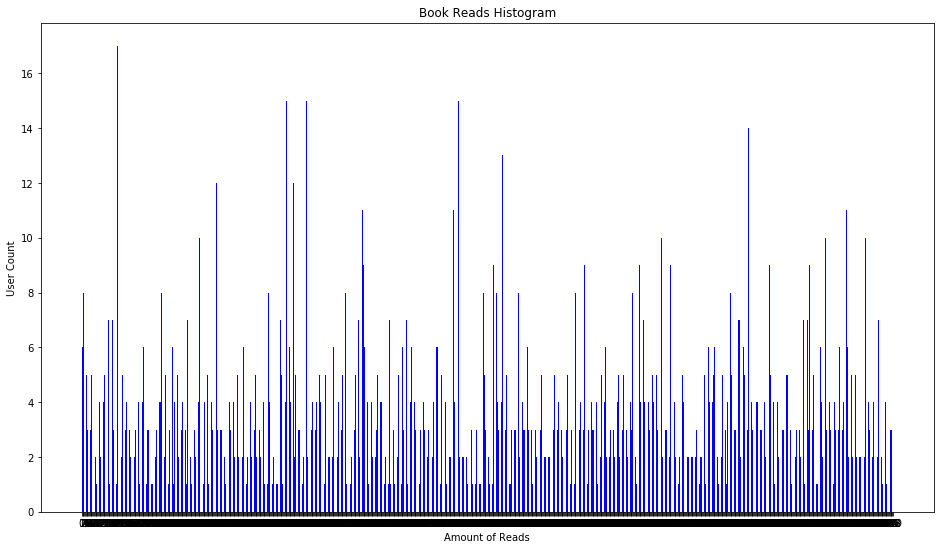

In [107]:
# Plot read distrbution

degreeCount = {b:len(u) for (b,u) in booksUsers.items()}
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(16,9))

plt.bar(deg, cnt, width=0.50, color='b')
plt.title("Book Reads Histogram")
plt.ylabel("User Count")
plt.xlabel("Amount of Reads")

ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)

plt.show()